# COPPER-GOLD RATIO AS A KEY ECONOMIC INDICATOR
### The Pandastic 4:
Jordan Alvarado, Rajesh Berigei, Isabelle Bertrand, Serge Jaitapker

### GOAL:
This analysis investigates whether the gold-copper spread (ratio) is a reliable indicator of economic health.

### HYPOTHESIS:
- Copper/Gold price ratio signals economic health
- Copper/Gold price ratio tends to increase (decrease) when expansion (contraction) is expected

# General Approach
## Data Procurement
- Procure daily Gold historical price history from MacroTrends/FRED/Quandl
- Procure daily Copper historical price history from MacroTrends/FRED/Quandl
- Procure daily market history data (e.g. S&P 500, Dow Jones, 10-year Treasury Bill yields)

## Data Wrangling/Processing
- Confirm date axis and column labels are consistent - edit .csv directly for quick edits
- Import daily history into pandas dataframe
- Normalize dates to have common start/end points (merge 'inner')
- Determine basic metrics on merged dataframe
- Add additional computed columns (commodity ratios) into dataframe

## Analysis
- Data mining to find useful economic patterns - via preliminary plots, smoothing, resampling (downsampling is easy from daily data)
- In particular, look at correlation with market indices such as S&P 500, Dow Jones
- Correlation could be cross-correlation or rolling window correlation. Initial analysis revealed several "piecewise regions" of interest
- Depending on results of analysis, attempt univariate regression - this may be useful in piecewise regions

## Visualizations and Conclusions
- Provide relevant visualizations with matplotlib, and (optionally) seaborn.
- Provide conclusions with caveats

In [1]:
# Import requisite packages
import os
import csv
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns  
import datetime as dt

In [3]:
# Import raw daily data for commodities (Copper, Gold), and markets (S&P500, Dow Jones, 10-year Treasury Bills)
# Create individual data frames from raw data - import date column as dataframe index
df_gold_daily = pd.read_csv('DATA/Au_daily_51Y.csv', header=0, parse_dates=[0], index_col='Date') # GOLD
df_copper_daily = pd.read_csv('DATA/Cu_daily_60Y.csv', header=0, parse_dates=[0], index_col='Date') # COPPER
df_sp500_daily = pd.read_csv('DATA/SP500_daily_92Y.csv', header=0, parse_dates=[0], index_col='Date') # S&P 500 index
df_tbill_daily = pd.read_csv('DATA/TBILL_daily_58Y.csv', header=0, parse_dates=[0], index_col='Date') # 10-year Treasure Bill yield
df_dow_daily = pd.read_csv('DATA/DOW_daily_105Y.csv', header=0, parse_dates=[0], index_col='Date') # Dow Jones index

In [4]:
# Data frame - check metrics
print("-----GOLD----")
print(df_gold_daily, print(df_gold_daily.count()))
print(df_gold_daily.columns)
print()
print("----COPPER----")
print(df_copper_daily, print(df_copper_daily.count()))
print()
print("---S&P500---")
print(df_sp500_daily, print(df_sp500_daily.count()))
print()
print("--TREASURY BILL--")
print(df_tbill_daily, print(df_tbill_daily.count()))
print()
print("--DOW--")
print(df_dow_daily, print(df_dow_daily.count()))

-----GOLD----
Value    13081
dtype: int64
              Value
Date               
1968-04-01    38.00
1968-04-02    37.60
1968-04-03    37.70
1968-04-04    36.70
1968-04-05    37.20
...             ...
2019-11-25  1459.45
2019-11-26  1457.65
2019-11-27  1459.80
2019-11-28  1457.55
2019-11-29  1456.35

[13081 rows x 1 columns] None
Index(['Value'], dtype='object')

----COPPER----
Value    15115
dtype: int64
             Value
Date              
1959-07-02  0.2930
1959-07-06  0.2910
1959-07-07  0.2820
1959-07-08  0.2846
1959-07-09  0.2760
...            ...
2019-11-19  2.6565
2019-11-20  2.6495
2019-11-21  2.6235
2019-11-22  2.6480
2019-11-25  2.6487

[15115 rows x 1 columns] None

---S&P500---
Value    24180
dtype: int64
              Value
Date               
1927-12-30    17.66
1927-12-31    17.66
1928-01-03    17.76
1928-01-04    17.72
1928-01-05    17.55
...             ...
2019-11-25  3133.64
2019-11-26  3140.52
2019-11-27  3153.63
2019-11-29  3140.98
2019-12-02  3113.87

[24180 ro

### The timeseries date start and end times do not match. The series are different lengths.
### Need to merge individual dataframes into master dataframe via "inner" to only keep common rows

In [6]:
# Merge data frames
# Since the datasets have the same frequency (daily), but not the same length (history), we will merge via "inner" (set intersection) 

# Merge market data
df_markets_temp = pd.merge(df_sp500_daily, df_dow_daily, on='Date', how='inner', suffixes=('_SP500', '_DOW'))
df_markets = pd.merge(df_markets_temp, df_tbill_daily, on='Date', how='inner')

# Merge commodities data
df_commodities = pd.merge(df_gold_daily, df_copper_daily, on='Date', how='inner', suffixes=('_Gold', '_Copper'))

# Merge markets with commodities data
df_clean = pd.merge(df_markets, df_commodities, on='Date', how='inner')

# Correct column name for T-Bills
df_clean = df_clean.rename(columns={"Value":"Value_TBILL"})

In [7]:
# Check merged dataframe
df_clean

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper
Date,,,,,
1968-04-01,92.48,861.25,5.64,38.00,0.5900
1968-04-02,92.64,863.96,5.62,37.60,0.5700
1968-04-03,93.47,869.11,5.49,37.70,0.5500
1968-04-04,93.84,872.52,5.52,36.70,0.5495
1968-04-05,93.29,865.81,5.52,37.20,0.5600
...,...,...,...,...,...
2019-11-19,3120.18,27934.02,1.79,1464.90,2.6565
2019-11-20,3108.46,27821.09,1.73,1475.70,2.6495
2019-11-21,3103.54,27766.29,1.77,1468.90,2.6235


### Add computed columns for subsequent analysis

In [9]:
# Add computed Au/Cu ratio column
df_clean['Gold_Copper_Ratio'] = df_clean['Value_Gold'] / df_clean['Value_Copper']

# Add computed Cu/Au (reciprocal) column for possible subsequent analysis paths
df_clean['Copper_Gold_Ratio'] = 1 / df_clean['Gold_Copper_Ratio']

# Scale Cu/Au ratio by 1000 for possible better visualization later
df_clean['Copper_Gold_Ratio_1K'] = 1000.0*df_clean['Copper_Gold_Ratio']

# Scale Cu/Au ratio by 1E6 for possible better visualization later
df_clean['Copper_Gold_Ratio_1M'] = 1000000.0*df_clean['Copper_Gold_Ratio']

In [12]:
# Check
df_clean

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Date,,,,,,,,,
1968-04-01,92.48,861.25,5.64,38.00,0.5900,64.406780,0.015526,15.526316,15526.315789
1968-04-02,92.64,863.96,5.62,37.60,0.5700,65.964912,0.015160,15.159574,15159.574468
1968-04-03,93.47,869.11,5.49,37.70,0.5500,68.545455,0.014589,14.588859,14588.859416
1968-04-04,93.84,872.52,5.52,36.70,0.5495,66.787989,0.014973,14.972752,14972.752044
1968-04-05,93.29,865.81,5.52,37.20,0.5600,66.428571,0.015054,15.053763,15053.763441
...,...,...,...,...,...,...,...,...,...
2019-11-19,3120.18,27934.02,1.79,1464.90,2.6565,551.439864,0.001813,1.813434,1813.434364
2019-11-20,3108.46,27821.09,1.73,1475.70,2.6495,556.973014,0.001795,1.795419,1795.419123
2019-11-21,3103.54,27766.29,1.77,1468.90,2.6235,559.900896,0.001786,1.786030,1786.030363


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


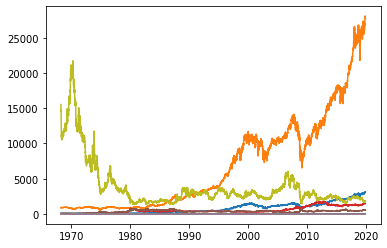

In [11]:
plt.plot(df_clean)

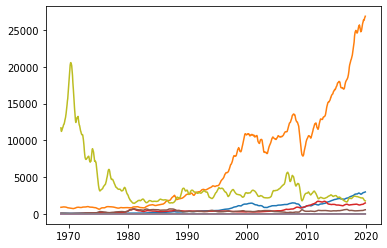

In [13]:
# Plot rolling everage (smoothed data)
# Reference: Python for Data Analysis - Chapter 11
smooth_factor = 90 # This is for 90 days
plt.plot(df_clean.rolling(smooth_factor).mean())

In [16]:
# Slice data to past 40 years - this brings dataframe to less than 10000 rows. Also it excludes some behavior prior to ~1980 that appears to be affected by other variables
# The df_40Y dataframe is limited to 1979 to 2019. We may expand this later depending on analysis outcome
df_40Y = df_clean["1979":"2019"]
df_40Y

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Date,,,,,,,,,
1979-01-02,96.73,811.42,9.18,227.15,0.7005,324.268380,0.003084,3.083865,3083.865287
1979-01-03,97.80,817.39,9.16,222.10,0.7040,315.482955,0.003170,3.169743,3169.743359
1979-01-04,98.58,826.14,9.11,222.50,0.7035,316.275764,0.003162,3.161798,3161.797753
1979-01-05,99.13,830.73,9.10,226.70,0.7065,320.877565,0.003116,3.116453,3116.453463
1979-01-08,98.80,828.14,9.14,224.10,0.7190,311.682893,0.003208,3.208389,3208.389112
...,...,...,...,...,...,...,...,...,...
2019-11-19,3120.18,27934.02,1.79,1464.90,2.6565,551.439864,0.001813,1.813434,1813.434364
2019-11-20,3108.46,27821.09,1.73,1475.70,2.6495,556.973014,0.001795,1.795419,1795.419123
2019-11-21,3103.54,27766.29,1.77,1468.90,2.6235,559.900896,0.001786,1.786030,1786.030363


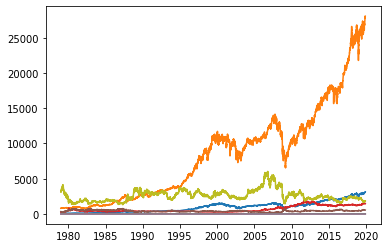

In [17]:
plt.plot(df_40Y)

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Date,,,,,,,,,
1979-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-11-19,2835.807973,25759.915726,2.498877,1321.475890,2.755036,481.696237,0.002100,2.100429,2100.429198
2019-11-20,2836.868603,25768.321205,2.495589,1321.946438,2.753863,482.061356,0.002099,2.098882,2098.882028
2019-11-21,2838.001973,25777.649534,2.492849,1322.403562,2.752661,482.430512,0.002097,2.097331,2097.331261


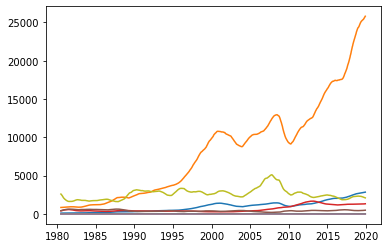

In [28]:
# Plot rolling everage (smoothed data)
df_40Y_smooth365 = df_40Y.rolling(365).mean()
df_40Y_smooth90 = df_40Y.rolling(90).mean()
df_40Y_smooth30 = df_40Y.rolling(30).mean()

plt.plot(df_40Y.rolling(365).mean())

df_40Y_smooth365


### Problem: the smoothing method works for visualization, but does not eliminate the NaN points
### Try resample (downsample to lower frequency) method next - save new dataframes for months, quarters, and years

In [19]:
# Resampling method. This actually eliminates non-zero (NaN) entries
# Reference: Python for Data Analysis - Chapter 11

# Resample monthly
df_40Y_resample_M = df_40Y.resample('M').mean()

# Resample quarterly
df_40Y_resample_Q = df_40Y.resample('Q').mean()

# Resample yearly
df_40Y_resample_Y = df_40Y.resample('Y').mean()

df_40Y_resample_M

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Date,,,,,,,,,
1979-01-31,99.705000,837.388636,9.099545,226.986364,0.737114,308.083330,0.003248,3.247749,3247.749114
1979-02-28,98.231111,825.190000,9.098333,245.144444,0.865522,283.440247,0.003531,3.530558,3530.558179
1979-03-31,100.112273,847.838636,9.117273,242.347727,0.923136,262.844970,0.003809,3.808998,3808.997965
1979-04-30,102.115789,865.192632,9.181579,239.173684,0.925147,258.839479,0.003869,3.868969,3868.968942
1979-05-31,99.794000,838.370000,9.245500,256.995000,0.850700,302.784732,0.003318,3.317804,3317.803880
...,...,...,...,...,...,...,...,...,...
2019-07-31,2996.113636,27089.186818,2.059091,1414.581818,2.692250,525.453568,0.001903,1.903299,1903.299477
2019-08-31,2898.408571,26065.355238,1.630476,1497.102381,2.580019,580.389549,0.001724,1.724310,1724.309888
2019-09-30,2982.156000,26900.214000,1.699500,1509.685000,2.614400,577.552052,0.001732,1.731965,1731.965380


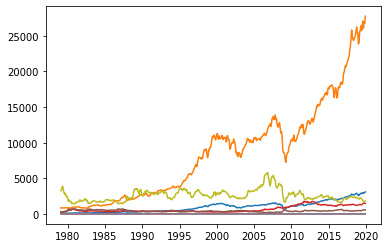

In [20]:
# Try plotting one
plt.plot(df_40Y_resample_M)

In [22]:
# Print some basic statistics for 1979-2019
df_40Y.describe()

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,975.303748,8497.962617,6.119454,650.041996,1.643155,417.955806,0.002602,2.601813,2601.812988
std,743.653676,6718.687247,3.312855,428.888266,1.079285,117.054040,0.000806,0.806320,806.319645
min,96.130000,759.130000,1.370000,216.550000,0.544000,165.596202,0.001300,1.299832,1299.832144
25%,311.320000,2470.180000,3.440000,349.500000,0.789500,330.759479,0.002045,2.044875,2044.874861
50%,951.130000,8519.230000,5.620000,409.000000,1.102500,410.761155,0.002435,2.434505,2434.504792
75%,1360.550000,11951.910000,8.260000,1004.250000,2.656000,489.027480,0.003023,3.023345,3023.344948
max,3133.640000,28066.470000,15.840000,1891.000000,4.628500,769.330105,0.006039,6.038786,6038.785835


In [23]:
# write clean data to csv file
df_clean.to_csv('df_clean.csv', ',')
df_40Y.to_csv('df_40Y.csv', ',')

# What follows is preliminary...

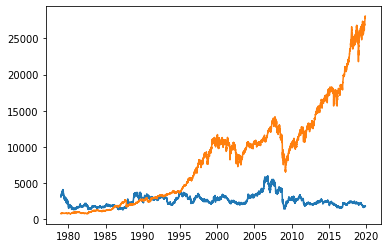

In [29]:
# Plot Copper_Gold ratio and Dow Jones index. We will likely use Cu/Au ratio instead of reciprocal Au/Cu for better visualization (positive correlation)
plt.plot(df_40Y['Copper_Gold_Ratio_1M'])
plt.plot(df_40Y['Value_DOW'])

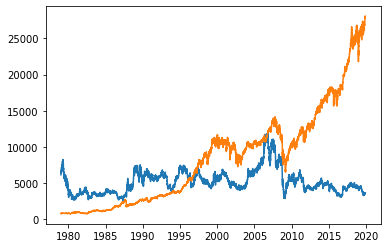

In [30]:
# Scale the ratio a bit
plt.plot(2*df_40Y['Copper_Gold_Ratio_1M'])
plt.plot(df_40Y['Value_DOW'])

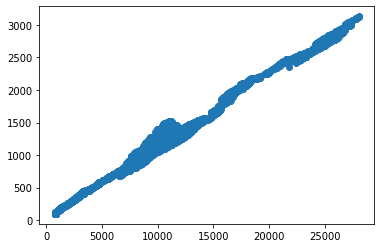

In [35]:
# Check if Dow is generally tracking with S&P 500
plt.scatter(df_40Y['Value_DOW'], df_40Y['Value_SP500'])

### It appears that for all intents and purposes, the Dow Jones and S&P 500 are tracking well so they can be used interchangeably for this project

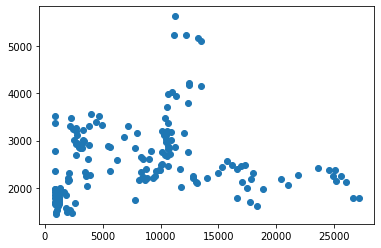

In [36]:
# Scatter plot of Cu/Au ratio with Dow (resampled to "quarterly" basis for better visualization)
plt.scatter(df_40Y['Value_DOW'].resample('Q').mean(), df_40Y['Copper_Gold_Ratio_1M'].resample('Q').mean())

### The scatter plot between the ratio and an index does not look too well-behaved
### Using the entire history likely requires analysis of multiple variables. There are also disruptive events that are likely impacting the data.
### This points to a piecewise analysis - there are likely several regions of interest.

In [37]:
# Run a correlation on 1979-2019 dataframe
df_40Y.corr()

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Value_SP500,1.000000,0.996632,-0.815747,0.696313,0.668424,-0.155462,0.105220,0.105220,0.105220
Value_DOW,0.996632,1.000000,-0.824091,0.726104,0.698455,-0.150171,0.100940,0.100940,0.100940
Value_TBILL,-0.815747,-0.824091,1.000000,-0.651565,-0.675827,0.304387,-0.215058,-0.215058,-0.215058
Value_Gold,0.696313,0.726104,-0.651565,1.000000,0.877560,0.118830,-0.139197,-0.139197,-0.139197
Value_Copper,0.668424,0.698455,-0.675827,0.877560,1.000000,-0.290720,0.317768,0.317768,0.317768
Gold_Copper_Ratio,-0.155462,-0.150171,0.304387,0.118830,-0.290720,1.000000,-0.926561,-0.926561,-0.926561
Copper_Gold_Ratio,0.105220,0.100940,-0.215058,-0.139197,0.317768,-0.926561,1.000000,1.000000,1.000000
Copper_Gold_Ratio_1K,0.105220,0.100940,-0.215058,-0.139197,0.317768,-0.926561,1.000000,1.000000,1.000000
Copper_Gold_Ratio_1M,0.105220,0.100940,-0.215058,-0.139197,0.317768,-0.926561,1.000000,1.000000,1.000000


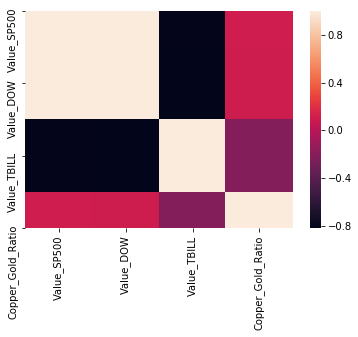

In [38]:
# USE SEABORN to generate correlation heat map

sns.heatmap(df_40Y[['Value_SP500', 'Value_DOW', 'Value_TBILL', 'Copper_Gold_Ratio']].corr())

### Using the 40 year data, the maximum correlation between the Cu/Au ratio and the Dow Jones index is 0.1. The T-bill correlation with Cu/Au is slightly better at -0.2 (inverse relation)

### Try zooming into a range that looks like it tracks well (based on earlier plots)...

(730851.0, 733773.0)

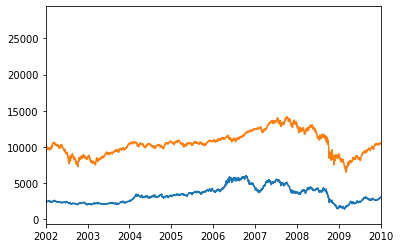

In [40]:
# Let's try zooming in to a limited range
plt.plot(df_40Y['Copper_Gold_Ratio_1M'])
plt.plot(df_40Y['Value_DOW'])
plt.xlim("2002","2010")

In [41]:
df_2002_2010 = df_40Y["2002":"2010"]
df_2002_2010

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Date,,,,,,,,,
2002-01-02,1154.67,10073.40,5.20,278.10,0.6580,422.644377,0.002366,2.366055,2366.055376
2002-01-03,1165.27,10172.14,5.16,278.65,0.6640,419.653614,0.002383,2.382918,2382.917639
2002-01-04,1172.51,10259.74,5.18,278.95,0.6745,413.565604,0.002418,2.417996,2417.996057
2002-01-07,1164.89,10197.05,5.09,279.65,0.7150,391.118881,0.002557,2.556767,2556.767388
2002-01-08,1160.71,10150.55,5.10,278.20,0.7085,392.660550,0.002547,2.546729,2546.728972
...,...,...,...,...,...,...,...,...,...
2010-12-22,1258.84,11559.49,3.36,1389.00,4.2720,325.140449,0.003076,3.075594,3075.593952
2010-12-23,1256.77,11573.49,3.41,1384.00,4.2560,325.187970,0.003075,3.075145,3075.144509
2010-12-29,1259.78,11585.38,3.35,1403.50,4.3085,325.751422,0.003070,3.069825,3069.825436


In [42]:
df_2002_2010.corr()

,Value_SP500,Value_DOW,Value_TBILL,Value_Gold,Value_Copper,Gold_Copper_Ratio,Copper_Gold_Ratio,Copper_Gold_Ratio_1K,Copper_Gold_Ratio_1M
Value_SP500,1.000000,0.985368,0.466112,0.139871,0.649030,-0.890724,0.856953,0.856953,0.856953
Value_DOW,0.985368,1.000000,0.389486,0.221334,0.690086,-0.842873,0.806829,0.806829,0.806829
Value_TBILL,0.466112,0.389486,1.000000,-0.624394,-0.129340,-0.524201,0.535230,0.535230,0.535230
Value_Gold,0.139871,0.221334,-0.624394,1.000000,0.779213,-0.064304,0.043243,0.043243,0.043243
Value_Copper,0.649030,0.690086,-0.129340,0.779213,1.000000,-0.630234,0.643349,0.643349,0.643349
Gold_Copper_Ratio,-0.890724,-0.842873,-0.524201,-0.064304,-0.630234,1.000000,-0.944774,-0.944774,-0.944774
Copper_Gold_Ratio,0.856953,0.806829,0.535230,0.043243,0.643349,-0.944774,1.000000,1.000000,1.000000
Copper_Gold_Ratio_1K,0.856953,0.806829,0.535230,0.043243,0.643349,-0.944774,1.000000,1.000000,1.000000
Copper_Gold_Ratio_1M,0.856953,0.806829,0.535230,0.043243,0.643349,-0.944774,1.000000,1.000000,1.000000


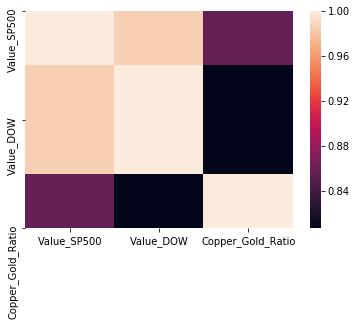

In [43]:
sns.heatmap(df_2002_2010[['Value_SP500', 'Value_DOW', 'Copper_Gold_Ratio']].corr())

### Much better!
### Cu/Au correlation with Dow Jones is 0.81, even better with S&P 500 at 0.86 !!

# Next steps
- Do a cross-corretion study between an index and the Cu/Au ratio - this is better for timeseries data. This could also be a "rolling correlation" since we know that the correlation changes drastically depending on the region. It would be useful to get a "correlation history" using a window of 30-90 days for example.
- Split history into regions - in particularly 2002-2010 to start
- Investigate regression fit on well-behaved regions

In [ ]:
### STATSMODELS ###

import statsmodels.formula.api as smf

# Create a fitted model
lm = smf.ols(formula='Copper_Gold_Ratio_1M ~ Value_DOW', data=df_40Y).fit()

# Print the coefficients
lm.params